In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import pickle 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import linear_model

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71.0,115.0,2960.0,16.59,0.0,0.0,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,248.682615,0.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71.0,115.0,2960.0,16.59,0.0,0.0,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,NaN,1.0,12.0,26.500150,1.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71.0,115.0,2960.0,16.59,0.0,0.0,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,NaN,1.0,12.0,24.693619,2.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71.0,115.0,2960.0,16.59,0.0,0.0,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,NaN,1.0,12.0,48.406926,3.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71.0,115.0,2960.0,16.59,0.0,0.0,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,3.899395,4.0


## Check Data Types

In [ ]:
print(train.dtypes)

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
                              ...   
direction_peak_wind_speed    float64
max_wind_speed               float64
days_with_fog                float64
site_eui                     float64
id                           float64
Length: 64, dtype: object


### Encode Categorical Variables

In [ ]:
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

## Visualizing missing data

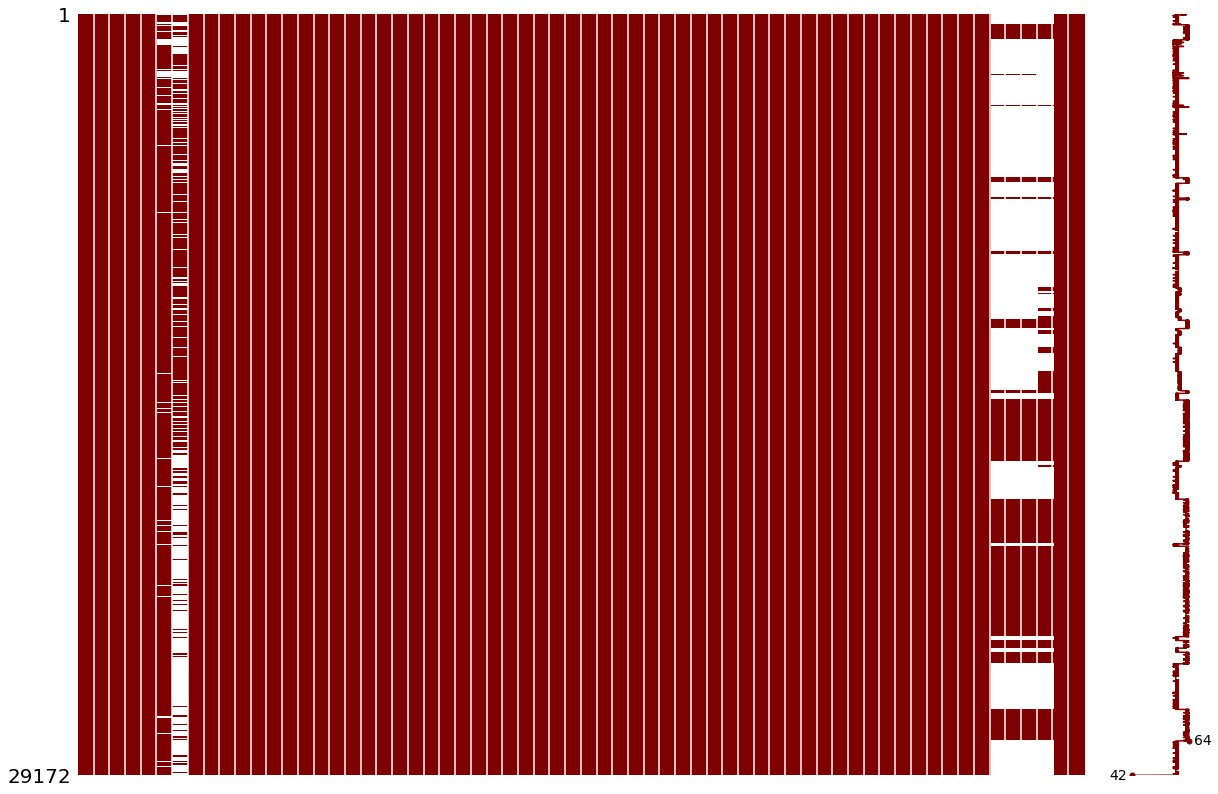

In [ ]:
msno.matrix(df=train, figsize=(10,10), color=(0.5,0,0)) #white lines are missing values

### Columns with missing values

In [ ]:
print('Training data:')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('Test data:')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(test.columns.values)[i] + ": " +str(n) + ' nans')

Training data+++++++++++
year_built: 1523 nans
energy_star_rating: 14633 nans
december_max_temp: 1 nans
cooling_degree_days: 1 nans
heating_degree_days: 1 nans
precipitation_inches: 1 nans
snowfall_inches: 1 nans
snowdepth_inches: 1 nans
avg_temp: 1 nans
days_below_30F: 1 nans
days_below_20F: 1 nans
days_below_10F: 1 nans
days_below_0F: 1 nans
days_above_80F: 1 nans
days_above_90F: 1 nans
days_above_100F: 1 nans
days_above_110F: 1 nans
direction_max_wind_speed: 18179 nans
direction_peak_wind_speed: 18217 nans
max_wind_speed: 18179 nans
days_with_fog: 16672 nans
site_eui: 1 nans
id: 1 nans
Testing data+++++++++++
year_built: 92 nans
energy_star_rating: 2254 nans
direction_max_wind_speed: 8575 nans
direction_peak_wind_speed: 8575 nans
max_wind_speed: 8575 nans
days_with_fog: 9117 nans


### Median Imputations

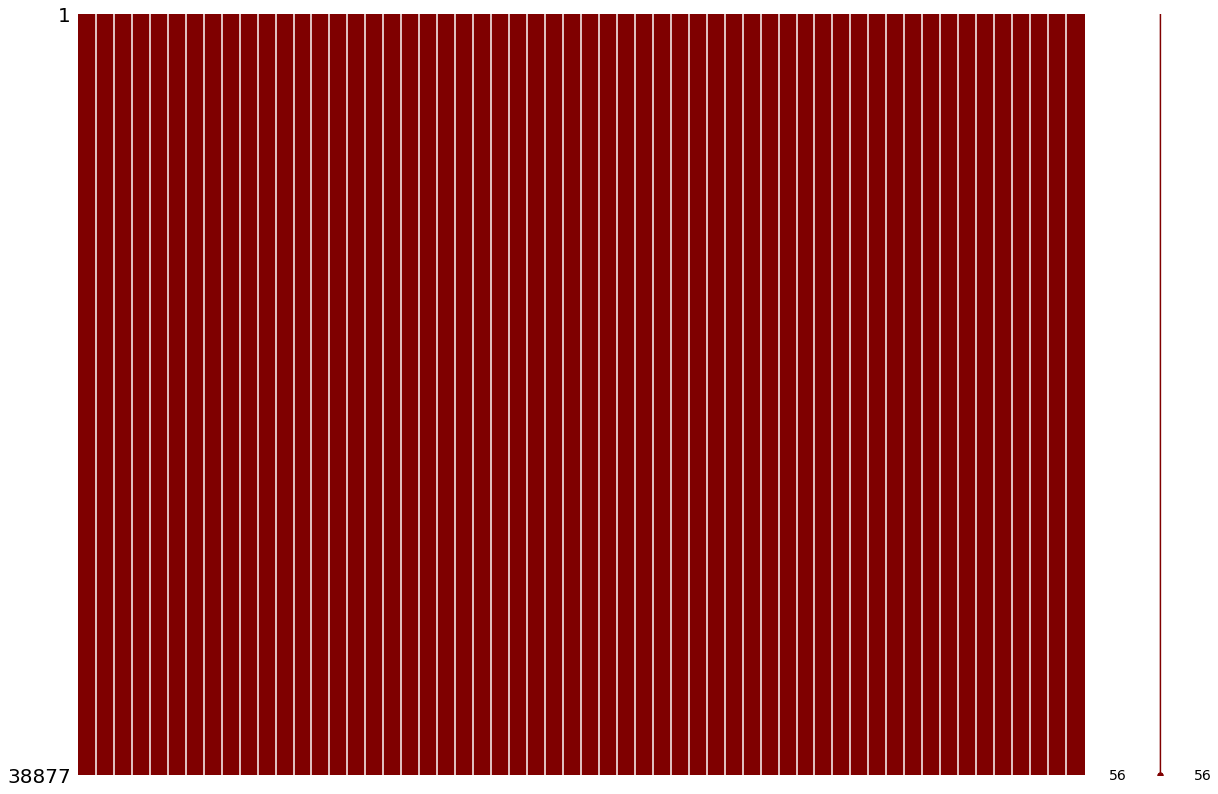

In [ ]:
train_ID = train['id']
test_ID = test['id']

# split the data for training
y_train = train['site_eui']
X_train = train.drop(['id', 'facility_type', 'site_eui', 'days_above_110F'], axis=1)
X_test = test.drop(['id', 'days_above_110F', 'facility_type'], axis=1)

# Drop the columns with (large amount) missing data
Xmat = pd.concat([X_train, X_test])
Xmat =Xmat.drop(['max_wind_speed', 'days_with_fog', 'direction_peak_wind_speed','direction_max_wind_speed'], axis =1)
Xmat = Xmat.fillna(Xmat.median())

msno.matrix(df=Xmat, figsize=(10,10), color=(0.5,0,0))

### Check the distribution of response variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


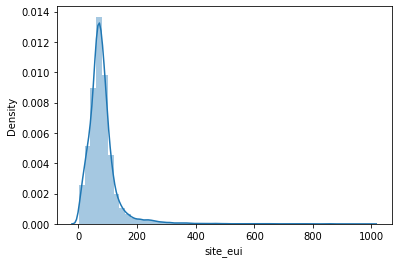

In [ ]:
ax = sns.distplot(y_train)
plt.show()

### Distribution of response is right skewed (need to normalize)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


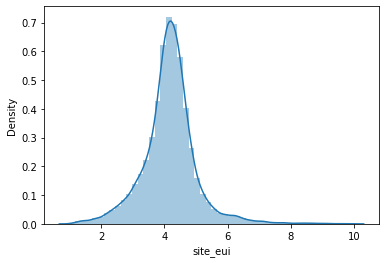

In [ ]:
y_train = np.cbrt(y_train) # cube root transformation

ax = sns.distplot(y_train)
plt.show()

### Correlations between explanatory features

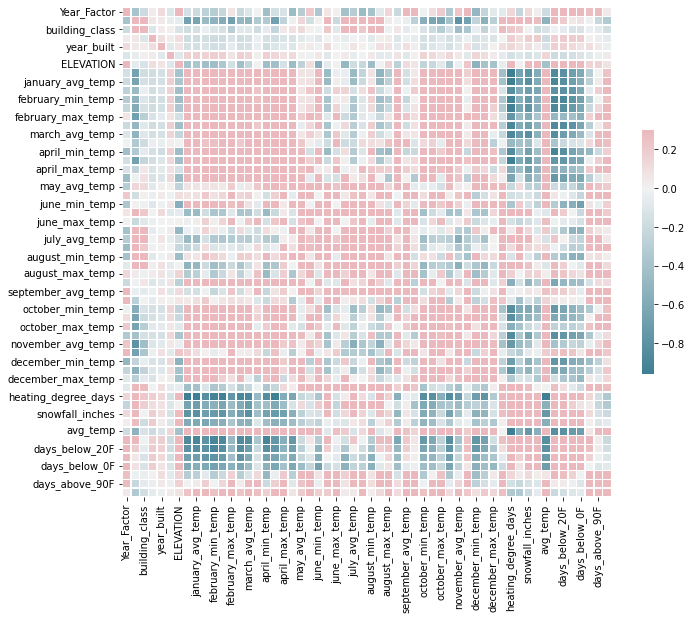

In [ ]:
# Check the correlation matrix
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# Compute correlation matrix
corr = X_train.corr()

# Set up the correlation matrix
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging color map
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [ ]:
y_train = y_train.dropna()
X_train = X_train.iloc[:-1,:]

### Feature Importance using Random Forest

Training done using Random Forest


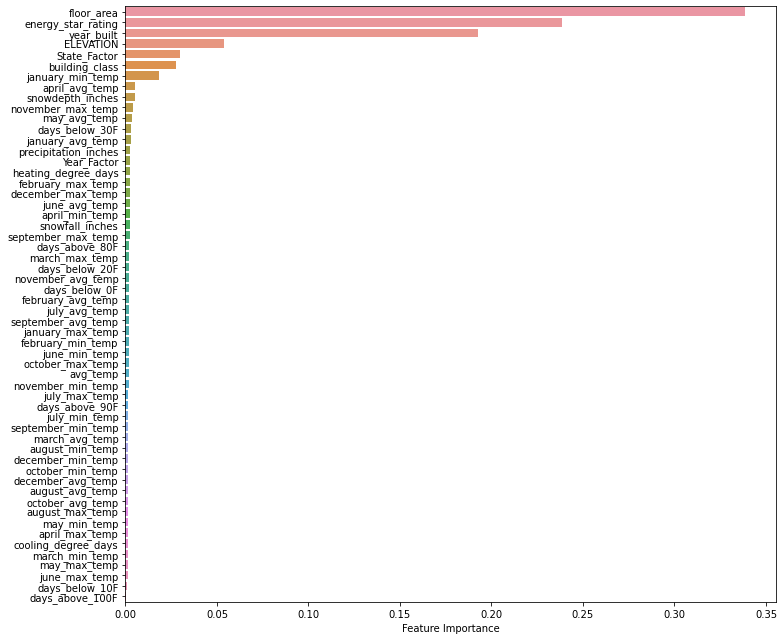

In [ ]:
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### Feature Engineering (creating interaction terms)

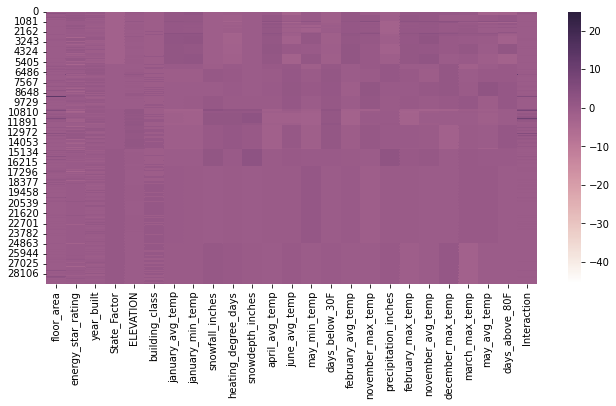

In [ ]:
X_train = X_train.loc[:,['floor_area','energy_star_rating','year_built','State_Factor','ELEVATION',
                         'building_class','january_avg_temp','january_min_temp','snowfall_inches','heating_degree_days',
                         'snowdepth_inches','april_avg_temp','june_avg_temp','may_min_temp', 'days_below_30F',
                         'february_avg_temp','november_max_temp','precipitation_inches','february_max_temp',
                         'november_avg_temp','december_max_temp', 'march_max_temp','may_avg_temp','days_above_80F']]
X_test = X_test.loc[:,['floor_area','energy_star_rating','year_built','State_Factor','ELEVATION',
                         'building_class','january_avg_temp','january_min_temp','snowfall_inches','heating_degree_days',
                         'snowdepth_inches','april_avg_temp','june_avg_temp','may_min_temp', 'days_below_30F',
                         'february_avg_temp','november_max_temp','precipitation_inches','february_max_temp',
                         'november_avg_temp','december_max_temp', 'march_max_temp','may_avg_temp','days_above_80F']]


X_train["Interaction"] = X_train["floor_area"]*X_train["energy_star_rating"]
X_test["Interaction"] = X_test["floor_area"]*X_test["energy_star_rating"]

X_train["Interaction"] = X_train["floor_area"]*X_train["ELEVATION"]
X_test["Interaction"] = X_test["floor_area"]*X_test["ELEVATION"]

# We'll use z-scoring for our values to standardize the data
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
    
# heatmap
f, ax = plt.subplots(figsize=(11, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(X_train, cmap=cmap)
plt.show()

### Linearity of features and their importance towards Site_EUI

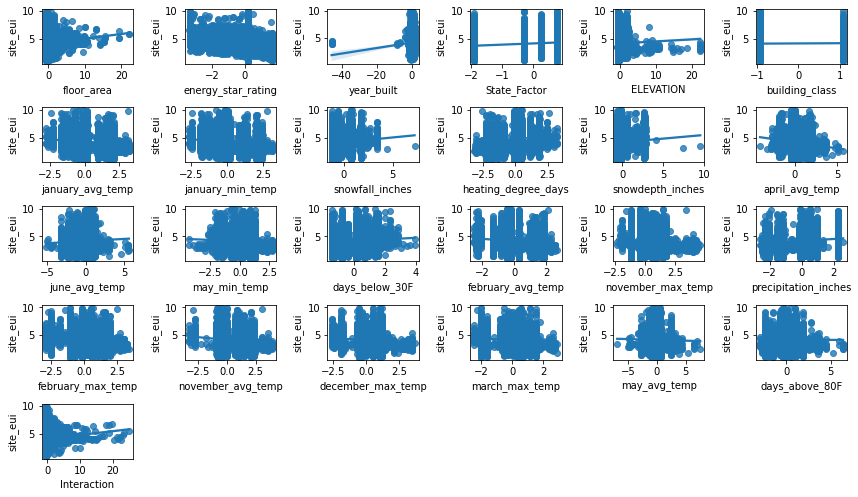

In [ ]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(25):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

###  Outliers

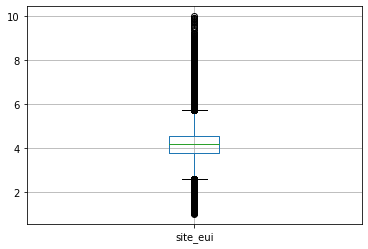

In [ ]:
pd.DataFrame(y_train).boxplot()

### Remove outliers

In [ ]:
Xmat = X_train
Xmat['site_eui'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['snowdepth_inches']>2.5) & (Xmat['site_eui']>9)].index)
Xmat = Xmat.drop(Xmat[(Xmat['snowfall_inches']>3) & (Xmat['site_eui']>9)].index)

# Make our training and test set ready for model analysis
y_train = Xmat['site_eui']
X_train = Xmat.drop(['site_eui'], axis=1)

### XGBoost

In [ ]:
print("Parameter Optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [2,4,6],
                       'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train,y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter Optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[20:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:53] WARNING: /workspa

In [ ]:
pred1 = reg_xgb.predict(X_test)
filename1 = 'xgb_model.sav'
pickle.dump(reg_xgb, open(filename1, 'wb'))

### Neural Network

In [ ]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
reg_dl.fit(X_train, y_train)

print(reg_dl.best_score_)
print(reg_dl.best_params_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
pred2 = reg_dl.predict(X_test)

filename2 = 'dl_model.sav'
pickle.dump(reg_dl, open(filename2, 'wb'))

### Support Vector Regressor

In [ ]:
reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                      param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                                 "gamma": np.logspace(-2,2,5)})# 

reg_svr.fit(X_train, y_train)

print(reg_svr.best_score_)
print(reg_svr.best_params_)

NameError: ignored

In [ ]:
pred3 = reg_svr.predict(X_test)

filename3 = 'svr_model.sav'
pickle.dump(reg_svr, open(filename3, 'wb'))

### Gradient Boosting Regressor

In [ ]:
param_test1 = {'n_estimators':range(20,81,10), 'learning_rate': (0.1,0.5, 0.15)}
reg_gbm = GridSearchCV(GradientBoostingRegressor(min_samples_split=250,min_samples_leaf=50,
                                                  max_depth=8), cv=3,
                                                  param_grid= param_test1) 

reg_gbm.fit(X_train, y_train)

print(reg_gbm.best_score_)
print(reg_gbm.best_params_)

0.013615972363209475
{'learning_rate': 0.1, 'n_estimators': 20}


In [ ]:
pred4 = reg_gbm.predict(X_test)

filename4 = 'gbr_model.sav'
pickle.dump(reg_gbm, open(filename4, 'wb'))

In [ ]:
# putting all model predictions into a df
X_train2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_train),
     'NN': reg_dl.predict(X_train).ravel(),
     'SVR': reg_svr.predict(X_train),
     'GBR': reg_gbm.predict(X_train)
    })
X_train2.head()

### Linear Regression for Ensemble Modelling: 

Weighted average of prediction accuracy calculated. Models with higher accuracy will be given more weight. 

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_test),
     'DL': reg_dl.predict(X_test).ravel(),
     'SVR': reg_svr.predict(X_test),
     'GBR': reg_gbm.predict(X_test)
    })

y_pred = (reg.predict(X_test2))^3